In [4]:
import firebase_admin
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from firebase_admin import credentials, firestore
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Firebase Initialization
cred = credentials.Certificate("../adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['10000', '10002', '10004', '10007', '10008', '10009']
ACTIVITIES = ['walk', 'stairs']
SAMPLING_RATE = 100
OVERLAP = 0.50
CHUNK_SIZE = 1
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001
DIFF_THRESHOLD = 35

In [5]:
def fetch_data_by_treatment(treatment_filter):
    data_raw, docs = [], []
    data_ref = db.collection("data").document(treatment_filter)

    for patient_id in INCLUDE_ONLY:
        subject_ref = data_ref.collection(patient_id)
        for activity in ACTIVITIES:
            activity_ref = subject_ref.document(activity)
            phone_location_col = activity_ref.collections()

            for phone_location in phone_location_col:
                for recording in phone_location.stream():
                    record = recording.to_dict()
                    if 'acceleration' not in record:
                        continue
                    df = pd.DataFrame(record['acceleration'])
                    timestamps = df['timestamp']
                    min_time = timestamps.min()
                    max_time = timestamps.max()
                    df = df[(timestamps >= min_time + 2500) & (timestamps <= max_time - 2500)]
                    if df.empty:
                        continue
                    combined = pd.DataFrame({
                        'ax': df['accelerometer'].apply(lambda x: x['x']),
                        'ay': df['accelerometer'].apply(lambda x: x['y']),
                        'az': df['accelerometer'].apply(lambda x: x['z']),
                        'gx': df['gyroscope'].apply(lambda x: x['x']),
                        'gy': df['gyroscope'].apply(lambda x: x['y']),
                        'gz': df['gyroscope'].apply(lambda x: x['z']),
                    })
                    data_raw.append(combined)
                    docs.append({'activity': activity})
    return data_raw, docs

def chunk_data_raw(data_raw, docs, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    data, labels = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))
    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start + chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk.values)
                labels.append(ACTIVITIES.index(docs[i]['activity']))
    return np.array(data), np.array(labels)

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=6, emb_size=128, nhead=8, nhid=128, nlayers=3, nclasses=len(ACTIVITIES), dropout=0.1):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, emb_size),
            nn.LayerNorm(emb_size)  # LayerNorm
        )
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.dropout_fc = nn.Dropout(0.3)  # Dropout before classifier

        # MLP head instead of single linear
        self.classifier = nn.Sequential(
            nn.Linear(emb_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, nclasses)
        )
        self.emb_size = emb_size

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.emb_size)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.dropout_fc(x)
        x = self.classifier(x)
        return x

In [8]:
def train_and_evaluate_after_only():
    # Fetch and prepare all AfterTreatment data
    after_raw, after_docs = fetch_data_by_treatment('AfterTreatment')
    X_full, y_full = chunk_data_raw(after_raw, after_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    # Split into train, val, and test
    X_train_np, X_temp, y_train_np, y_temp = train_test_split(
        X_full, y_full, test_size=0.3, random_state=42, stratify=y_full
    )
    X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Normalize features
    scaler = StandardScaler()
    X_train_np = scaler.fit_transform(X_train_np.reshape(-1, 6)).reshape(X_train_np.shape)
    X_val_np   = scaler.transform(X_val_np.reshape(-1, 6)).reshape(X_val_np.shape)
    X_test_np  = scaler.transform(X_test_np.reshape(-1, 6)).reshape(X_test_np.shape)

    # Convert to tensors
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train_np, dtype=torch.long)
    X_val = torch.tensor(X_val_np, dtype=torch.float32)
    y_val = torch.tensor(y_val_np, dtype=torch.long)
    X_test = torch.tensor(X_test_np, dtype=torch.float32)
    y_test = torch.tensor(y_test_np, dtype=torch.long)

    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)

    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerClassifier().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    # Manual warmup + cosine decay parameters
    warmup_epochs = 10
    total_epochs = EPOCHS

    best_val_acc = 0

    for epoch in range(total_epochs):
        # ---- Adjust learning rate manually ----
        if epoch < warmup_epochs:
            lr_scale = 0.1 + 0.9 * (epoch / warmup_epochs)  # Linear warmup
        else:
            lr_scale = 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))  # Cosine decay
        for pg in optimizer.param_groups:
            pg['lr'] = LEARNING_RATE * lr_scale

        # ---- Training ----
        model.train()
        total_correct, total = 0, 0
        all_train_preds, all_train_labels = [], []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
            all_train_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_train_labels.extend(yb.cpu().numpy())

        train_acc = total_correct / total * 100
        train_bal_acc = balanced_accuracy_score(all_train_labels, all_train_preds) * 100

        # ---- Validation ----
        model.eval()
        val_correct, val_total = 0, 0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_total += yb.size(0)
                all_val_preds.extend(preds.argmax(dim=1).cpu().numpy())
                all_val_labels.extend(yb.cpu().numpy())

        val_acc = val_correct / val_total * 100
        val_bal_acc = balanced_accuracy_score(all_val_labels, all_val_preds) * 100

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f"Epoch {epoch+1}/{total_epochs} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
              f"Train Acc: {train_acc:.2f}% | Train BalAcc: {train_bal_acc:.2f}% | "
              f"Val Acc: {val_acc:.2f}% | Val BalAcc: {val_bal_acc:.2f}%")

    # ---- Test evaluation (final model) ----
    model.eval()
    test_correct, test_total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            test_correct += (preds.argmax(dim=1) == yb).sum().item()
            test_total += yb.size(0)
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    test_acc = test_correct / test_total * 100
    test_bal_acc = balanced_accuracy_score(all_labels, all_preds) * 100

    print(f"\nTest Accuracy (AfterTreatment only): {test_acc:.2f}%")
    print(f"Test Balanced Accuracy: {test_bal_acc:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=ACTIVITIES))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title('Test Confusion Matrix (AfterTreatment only)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return best_val_acc, test_acc, test_bal_acc

Epoch 1/50 | LR: 0.000100 | Train Acc: 56.41% | Train BalAcc: 57.43% | Val Acc: 74.90% | Val BalAcc: 74.24%
Epoch 2/50 | LR: 0.000190 | Train Acc: 69.94% | Train BalAcc: 69.36% | Val Acc: 77.78% | Val BalAcc: 76.87%
Epoch 3/50 | LR: 0.000280 | Train Acc: 78.60% | Train BalAcc: 77.82% | Val Acc: 86.83% | Val BalAcc: 85.61%
Epoch 4/50 | LR: 0.000370 | Train Acc: 87.89% | Train BalAcc: 87.49% | Val Acc: 96.71% | Val BalAcc: 96.60%
Epoch 5/50 | LR: 0.000460 | Train Acc: 93.90% | Train BalAcc: 93.89% | Val Acc: 94.65% | Val BalAcc: 94.64%
Epoch 6/50 | LR: 0.000550 | Train Acc: 95.40% | Train BalAcc: 95.35% | Val Acc: 97.53% | Val BalAcc: 97.35%
Epoch 7/50 | LR: 0.000640 | Train Acc: 96.73% | Train BalAcc: 96.66% | Val Acc: 98.35% | Val BalAcc: 98.26%
Epoch 8/50 | LR: 0.000730 | Train Acc: 97.17% | Train BalAcc: 97.11% | Val Acc: 98.35% | Val BalAcc: 98.42%
Epoch 9/50 | LR: 0.000820 | Train Acc: 97.44% | Train BalAcc: 97.36% | Val Acc: 95.88% | Val BalAcc: 96.16%
Epoch 10/50 | LR: 0.000910 |

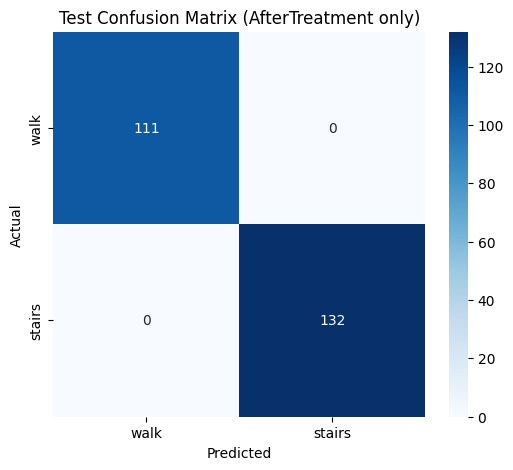

In [9]:
if __name__ == "__main__":
    train_and_evaluate_after_only()